dataset = "dialogsum" | "samsum"

dataset_type = "train" | "test" | "validation"

In [ ]:
from datasets import load_dataset
import json, pandas as pd, numpy as np 
from tqdm import tqdm
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util

In [118]:
dataset = "samsum"
dataset_type = "test"
save_result_comets = False


FILTERED_COMET_FILE_PATH = f"./comet_{dataset_type}_merged.json"
DIALOGSUM_FILE_PATH =  f"./dialogsum.{dataset_type}.jsonl"
FILE_OUTPUT_FOLDER = "."

In [ ]:
summary_dict = None
dilaogsum = None
if dataset == "samsum":
    samsum = load_dataset('samsum')
    summary_dict = dict([(obj["id"], obj["summary"]) for obj in samsum[dataset_type]])
elif dataset == "dialogsum":
       dilaogsum = pd.read_json(path_or_buf=DIALOGSUM_FILE_PATH, lines=True)
       summary_dict = dict([(obj["fname"], obj["summary"]) for _, obj in dilaogsum[["fname","summary"]].iterrows()])
else:
    raise NotImplementedError()

In [ ]:
comet = None
with open(FILTERED_COMET_FILE_PATH) as f:
    comet = json.loads(f.read())

In [ ]:
cs_unraveled = []
for sample_id, sammple_cs in comet.items():
    for sentence_num, sentence_obj in enumerate(sammple_cs):
        for cs_key_or_sentence, cs_arr_or_sentence in sentence_obj.items():
            if type(cs_arr_or_sentence) == type([]):
                for cs in cs_arr_or_sentence:
                    cs_unraveled.append({"sample_id":sample_id,"sentence_id":sentence_num, \
                    "sentence":sentence_obj["sentence"], "cs_type":cs_key_or_sentence, "cs":cs, "summary":summary_dict[sample_id]})

In [ ]:
len([obj["sentence"] for obj in cs_unraveled]) == sum([len(sentences) for _, sentences in comet.items()])*25

True

### Model details:
https://github.com/UKPLab/sentence-transformers

In [ ]:
sbert = SentenceTransformer('all-MiniLM-L6-v2', device='cuda')

In [ ]:
cs_unraveled[0]

{'sample_id': '13611370',
 'sentence_id': 0,
 'sentence': 'Derek: Judy, r you leaving for the weekend?',
 'cs_type': 'HinderedBy',
 'cs': ' They have to go to work.',
 'summary': 'Judy is staying for the weekend. Derek asks Judy to feed his animals on Friday and Saturday. Judy agrees. Derek will give her his keys on Thursday and provide Judy with details.'}

In [ ]:
cs_final= []
for cs_obj in tqdm(cs_unraveled):
    cs_emb =  sbert.encode(cs_obj["cs"])
    summary_emb = sbert.encode(cs_obj["summary"])
    sentence_emb = sbert.encode(cs_obj["sentence"])
    cs_final.append({**cs_obj,
                     "sentence_encoded":sentence_emb,"cs_encoded":cs_emb, "sumary_encoded":summary_emb,
                     "cos_similary_cs_summmary":float(util.cos_sim(cs_emb, summary_emb)),
                     "cos_similary_cs_sentence":float(util.cos_sim(cs_emb, sentence_emb))})

100%|██████████| 100/100 [00:03<00:00, 33.28it/s]


In [ ]:
cs_dp = pd.DataFrame(cs_final)

In [304]:
#dataset_type = "test"
#cs_dp =  pd.read_pickle(f"comet_samsum_{dataset_type}_z_entire.pkl")#.iloc[:500,:]

In [305]:
cs_dp.iloc[:2,:]

,sample_id,sentence_id,sentence,cs_type,cs,cs_encoded,summary,cos_similary_cs_summmary,cos_similary_cs_sentence
0,13611370,0,"Derek: Judy, r you leaving for the weekend?",HinderedBy,They have to go to work.,"[0.0059203124, -0.009283224, 0.010029693, 0.05...",Judy is staying for the weekend. Derek asks Ju...,0.316470,0.222532
1,13611370,0,"Derek: Judy, r you leaving for the weekend?",HinderedBy,The weekend is already booked up.,"[0.017274672, -0.036981095, 0.03747749, 0.0355...",Judy is staying for the weekend. Derek asks Ju...,0.395057,0.392030


In [306]:
set(cs_dp["cs_encoded"].transform(len))

{384}

In [307]:
cs_dp["cs_encoded"][0].dtype

dtype('float32')

In [309]:
best_cs_per_sentence_ours = cs_dp.loc[cs_dp.groupby(['sample_id','sentence_id'])['cos_similary_cs_summmary'].idxmax()]

In [310]:
best_cs_per_sentence_theirs = cs_dp.loc[cs_dp.groupby(['sample_id','sentence_id'])['cos_similary_cs_sentence'].idxmax()]

In [311]:
peaks_ours = best_cs_per_sentence_ours["cos_similary_cs_summmary"]
peaks_theirs = best_cs_per_sentence_theirs["cos_similary_cs_sentence"]

In [312]:
np.average(peaks_ours), np.std(peaks_ours)

(0.3440381035208702, 0.12068920757715909)

In [313]:
np.average(peaks_theirs), np.std(peaks_theirs)

(0.5043267078697682, 0.19893338561498167)

<AxesSubplot: xlabel='cs_type'>

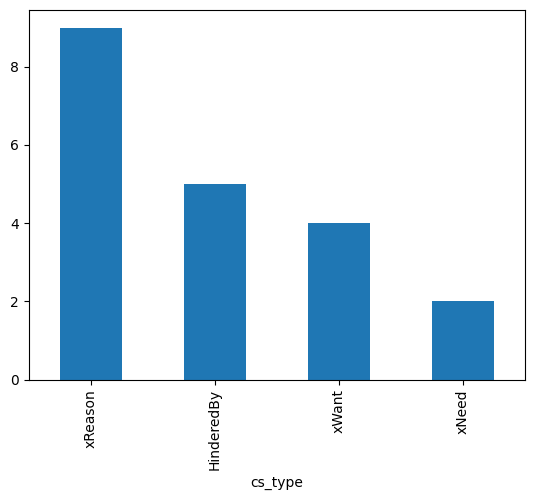

In [314]:
best_cs_per_sentence_ours['cs_type'].value_counts().plot.bar()

<AxesSubplot: xlabel='cs_type'>

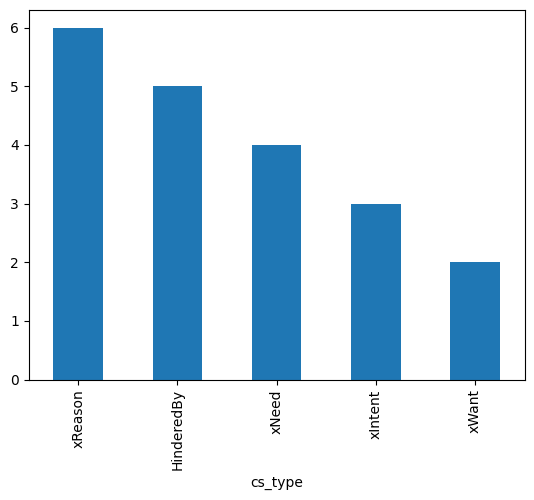

In [315]:
best_cs_per_sentence_theirs['cs_type'].value_counts().plot.bar()

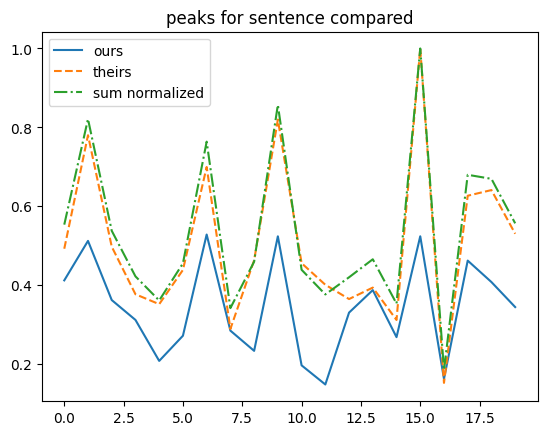

In [316]:

max_drow = 70
plt.plot(range(0,len(peaks_ours[:max_drow])),peaks_ours[:max_drow],  label ="ours")
plt.plot(range(0,len(peaks_theirs[:max_drow])), peaks_theirs[:max_drow],  label ="theirs", linestyle="--")
plt.plot(range(0,len(peaks_theirs[:max_drow])), np.array([n1+n2/2 for n1, n2 in zip(peaks_theirs[:max_drow], peaks_ours[:max_drow])])/max([n1+n2/2 for n1, n2 in zip(peaks_theirs[:max_drow], peaks_ours[:max_drow])]),  label ="sum normalized", linestyle="-.")
plt.title("peaks for sentence compared")
plt.legend() 
plt.show()

In [317]:
def convert_back_to_dict(df):
    converted_df = {}
    for _, row in df.iterrows():
        if converted_df.get(str(row["sample_id"])):
            converted_df[str(row["sample_id"])][str(row["sentence_id"])] = \
                {"sentence":row["sentence"], "relation":row["cs_type"], "out":row["cs"]}
        else:  converted_df[str(row["sample_id"])] = \
            {str(row["sentence_id"]): {"sentence":row["sentence"], "relation":row["cs_type"], "out":row["cs"]}}
    return converted_df

In [318]:
def save_files(converted_dfs_and_paths):
    for converted_df, path in converted_dfs_and_paths:
        with open(path, "w") as file:
            file.write(json.dumps(converted_df, indent=2))

In [319]:
if save_result_comets:
    converted_dfs_and_paths = [(convert_back_to_dict(best_cs_per_sentence_ours),\
                                f"{FILE_OUTPUT_FOLDER}/comet_{dataset}_{dataset_type}_z_ours.json"),\
                                (convert_back_to_dict(best_cs_per_sentence_theirs),\
                                f"{FILE_OUTPUT_FOLDER}/comet_{dataset}_{dataset_type}_z_theirs.json")]
    save_files(converted_dfs_and_paths)
    cs_dp[["sample_id", "sentence_id", "sentence", "cs_type", "cs","cs_encoded", "summary", "cos_similary_cs_summmary", "cos_similary_cs_sentence"]].to_pickle((f"{FILE_OUTPUT_FOLDER}/comet_{dataset}_{dataset_type}_z_entire.pkl"))